# Trajectory Recommendation

<a id='toc'></a>

[Table of Contents](#toc)
1. [Preprocess](#sec1)
  1. [Load Data](#sec1.1)
  1. [Utility function](#sec1.2)
1. [Factorise Transition Probabilities in POI Feature Space](#sec2)
  1. [POI Features for Factorisation](#sec2.1)
  1. [Transition Matrix between POI Cateogries](#sec2.2)
  1. [Transition Matrix between POI Popularity Classes](#sec2.3)
  1. [Transition Matrix between the Number of POI Visit Classes](#sec2.4)
  1. [Transition Matrix between POI Average Visit Duration Classes](#sec2.5)
  1. [Transition Matrix between POI Neighborhood Classes](#sec2.6)
  1. [Transition Matrix between POIs](#sec2.7)

<a id='sec1'></a>

# 1. Preprocess

In [1]:
% matplotlib inline

import os, sys, time
import math, itertools, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import kron
from scipy.misc import logsumexp
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
data_dir = 'data/data-recsys16'
suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']

Number of bins/clusters of POI features for each dataset.

In [3]:
dat_ix = 4

In [4]:
fpoi = os.path.join(data_dir, 'poi-' + suffix[dat_ix] + '.csv')
ftraj = os.path.join(data_dir, 'traj-all-' + suffix[dat_ix] + '.csv')

<a id='sec1.1'></a>

## 1.1 Load Data

In [5]:
traj_all = pd.read_csv(ftraj)
traj_all.head()

,#photo,endTime,poiID,startTime,trajID,trajLen,userID,poiDuration
0,1,1226726126,25,1226726126,0,1,10058801@N06,0
1,2,1205332541,58,1205332532,1,2,10087938@N02,9
2,2,1205342729,66,1205342722,1,2,10087938@N02,7
3,1,1205374109,59,1205374109,2,1,10087938@N02,0
4,1,1205417265,58,1205417265,3,1,10087938@N02,0


In [6]:
poi_all = pd.read_csv(fpoi)
poi_all.set_index('poiID', inplace=True)
poi_all.head()

,poiCat,poiLon,poiLat
poiID,,,
0,City precincts,144.96778,-37.82167
1,City precincts,144.94600,-37.81700
2,City precincts,144.97300,-37.81190
3,City precincts,144.96694,-37.79972
4,City precincts,144.96333,-37.80778


In [7]:
num_user = traj_all['userID'].unique().shape[0]
num_poi = traj_all['poiID'].unique().shape[0]
num_traj = traj_all['trajID'].unique().shape[0]
pd.DataFrame({'#user': num_user, '#poi': num_poi, '#traj': num_traj, '#traj/user': num_traj/num_user}, \
             index=[str(suffix[dat_ix])])

,#poi,#traj,#traj/user,#user
Melb,85,4918,5.911058,832


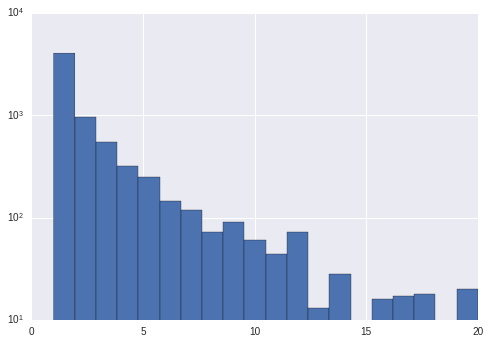

In [8]:
ax = traj_all['trajLen'].hist(bins=20)
ax.set_yscale('log')

Mapping trajectory to user.

In [9]:
traj_user = traj_all[['trajID', 'userID']].copy().groupby('trajID').first()
traj_user.head()

,userID
trajID,
0,10058801@N06
1,10087938@N02
2,10087938@N02
3,10087938@N02
4,10087938@N02


<a id='sec1.2'></a>

## 1.2 Utility function

Print computing progress.

In [10]:
def print_progress(cnt, total):
    """Display a progress bar"""
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

Extract trajectory, i.e., a list of POIs.

In [11]:
def extract_traj(tid, traj_all):
    traj = traj_all[traj_all['trajID'] == tid].copy()
    traj.sort_values(by=['startTime'], ascending=True, inplace=True)
    return traj['poiID'].tolist()

Compute POI properties, e.g., popularity, total number of visit, average visit duration.

In [12]:
def calc_poi_info(trajid_list, traj_all, poi_all):
    assert(len(trajid_list) > 0)
    # to allow duplicated trajid
    poi_info = traj_all[traj_all['trajID'] == trajid_list[0]][['poiID', 'poiDuration']].copy() 
    for i in range(1, len(trajid_list)):
        traj = traj_all[traj_all['trajID'] == trajid_list[i]][['poiID', 'poiDuration']]
        poi_info = poi_info.append(traj, ignore_index=True)
    
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiCat'] = poi_all.loc[poi_info.index, 'poiCat']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = traj_all[traj_all['trajID'].isin(trajid_list)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [13]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.0088 # mean earth radius is 6371.0088km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin(math.sqrt(\
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

In [14]:
trajid_set_all = sorted(traj_all['trajID'].unique().tolist())

In [15]:
print('#traj in total:', len(trajid_set_all))

#traj in total: 4918


In [16]:
poi_info_ = calc_poi_info(trajid_set_all, traj_all, poi_all)
poi_info_.head()

,avgDuration,nVisit,poiCat,poiLon,poiLat,popularity
poiID,,,,,,
0,389.647887,71,City precincts,144.96778,-37.82167,53
1,884.979167,48,City precincts,144.94600,-37.81700,36
2,1188.785124,121,City precincts,144.97300,-37.81190,78
3,401.436364,55,City precincts,144.96694,-37.79972,44
4,1434.607143,84,City precincts,144.96333,-37.80778,48


<a id='sec2'></a>

# 2. Factorise Transition Probabilities in POI Feature Space

Estimate a transition matrix for each feature of POI, transition probabilities (matrix) between different POI features (vector) is obtrained by the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of the individual transition matrix corresponding to each feature.

<a id='sec2.1'></a>

## 2.1 POI Features for Factorisation

POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
- Category of POI
- Popularity of POI (discritize with uniform log-scale bins, #bins <=5 )
- The number of POI visits (discritize with uniform log-scale bins, #bins <=5 )
- The average visit duration of POI (discritise with uniform log-scale bins, #bins <= 5)
- The neighborhood relationship between POIs (clustering POI(lat, lon) using k-means, #clusters <= 5)

The number of bins/clusters of POI features for all dataset, obtained by looking at the binning results (more uniform is better and the corresponding transition matrix of counts (denser is better).

In [17]:
nbins_df = pd.DataFrame(data=np.zeros((5, 4), dtype=np.int), \
                        columns=['Pop', 'Visit', 'Duration', 'Cluster'], \
                        index=['Osak', 'Glas', 'Edin', 'Toro', 'Melb'])

In [18]:
nbins_df.loc['Osak'] = [2, 2, 3, 4]
nbins_df.loc['Glas'] = [4, 4, 3, 3]
nbins_df.loc['Edin'] = [4, 3, 3, 3]
nbins_df.loc['Toro'] = [3, 3, 3, 3]
nbins_df.loc['Melb'] = [5, 4, 3, 5]

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a small number (i.e. $0.2$ times the minimum value of that row) if there exists a zero cell.

In [19]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        nonzeroidx = np.nonzero(transmat.iloc[row])[0].tolist()    
        if len(nonzeroidx) < transmat.columns.shape[0]:
            if len(nonzeroidx) == 0:  # all zeros in row
                transmat.iloc[row] = 1 / transmat.columns.shape[0]  # uniform distribution
            else:
                minv = np.min(transmat.iloc[row, nonzeroidx])
                EPS = 0.2 * minv  # row-specific smooth factor
                #zeroidx = list(set(range(len(transmat.columns))) - set(nonzeroidx))
                #transmat.iloc[row, zeroidx] = EPS
                transmat.iloc[row] += EPS
                rowsum = np.sum(transmat.iloc[row])
                assert(rowsum > 0)
                transmat.iloc[row] /= rowsum
        else:
            assert(len(nonzeroidx) == transmat.columns.shape[0])  # all non-zero in row
            transmat.iloc[row] /= np.sum(transmat.iloc[row])
    return transmat

POIs in training set.

In [20]:
poi_train_ = traj_all[traj_all['trajID'].isin(trajid_set_all)]['poiID'].unique().tolist()
poi_train_.sort()
#poi_train

<a id='sec2.2'></a>

## 2.2 Transition Matrix between POI Cateogries

In [21]:
poi_cats = poi_all.loc[poi_train_, 'poiCat'].unique().tolist()
poi_cats.sort()
poi_cats

['City precincts',
 'Entertainment',
 'Institutions',
 'Parks and spaces',
 'Public galleries',
 'Shopping',
 'Sports stadiums',
 'Structures',
 'Transport']

In [22]:
transmat_cat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                            columns=poi_cats, index=poi_cats)

Count the number of transitions between POI categories.

In [23]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            cat1 = poi_all.loc[p1, 'poiCat']
            cat2 = poi_all.loc[p2, 'poiCat']
            transmat_cat.loc[cat1, cat2] += 1

In [24]:
transmat_cat

,City precincts,Entertainment,Institutions,Parks and spaces,Public galleries,Shopping,Sports stadiums,Structures,Transport
City precincts,6,5,23,17,5,36,4,27,17
Entertainment,4,15,7,5,2,25,1,26,20
Institutions,21,9,54,54,2,84,5,43,21
Parks and spaces,18,9,41,67,5,44,19,63,55
Public galleries,6,3,7,6,4,5,1,7,6
Shopping,40,21,85,40,2,136,5,46,51
Sports stadiums,3,7,4,18,2,6,25,4,8
Structures,17,25,33,60,7,45,5,36,44
Transport,14,22,25,42,4,46,11,45,24


Normalise each row to obtain transition probabilities.

In [25]:
transmat_cat = normalise_transmat(transmat_cat)

In [26]:
transmat_cat

,City precincts,Entertainment,Institutions,Parks and spaces,Public galleries,Shopping,Sports stadiums,Structures,Transport
City precincts,0.042857,0.035714,0.164286,0.121429,0.035714,0.257143,0.028571,0.192857,0.121429
Entertainment,0.038095,0.142857,0.066667,0.047619,0.019048,0.238095,0.009524,0.247619,0.190476
Institutions,0.071672,0.030717,0.184300,0.184300,0.006826,0.286689,0.017065,0.146758,0.071672
Parks and spaces,0.056075,0.028037,0.127726,0.208723,0.015576,0.137072,0.059190,0.196262,0.171340
Public galleries,0.133333,0.066667,0.155556,0.133333,0.088889,0.111111,0.022222,0.155556,0.133333
Shopping,0.093897,0.049296,0.199531,0.093897,0.004695,0.319249,0.011737,0.107981,0.119718
Sports stadiums,0.038961,0.090909,0.051948,0.233766,0.025974,0.077922,0.324675,0.051948,0.103896
Structures,0.062500,0.091912,0.121324,0.220588,0.025735,0.165441,0.018382,0.132353,0.161765
Transport,0.060086,0.094421,0.107296,0.180258,0.017167,0.197425,0.047210,0.193133,0.103004


<a id='sec2.3'></a>

## 2.3 Transition Matrix between POI Popularity Classes

In [27]:
poi_pops = poi_info_.loc[poi_train_, 'popularity']
#sorted(poi_pops.unique().tolist())

Discretize POI popularity with uniform log-scale bins (#bins $\le 5$).

In [28]:
nbins_pop = nbins_df.loc[suffix[dat_ix], 'Pop']
print('Number of bins:', nbins_pop)

Number of bins: 5


In [29]:
expo_pop1 = np.log10(max(1, min(poi_pops)))
expo_pop2 = np.log10(max(poi_pops))
print(expo_pop1, expo_pop2)

0.0 2.41497334797


In [30]:
logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins_pop+1)
logbins_pop[0] = 0  # deal with underflow
logbins_pop

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

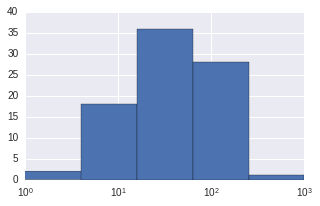

In [31]:
ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
ax.set_xscale('log')

In [32]:
transmat_pop = pd.DataFrame(data=np.zeros((nbins_pop, nbins_pop), dtype=np.float), \
                            columns=np.arange(1, nbins_pop+1), index=np.arange(1, nbins_pop+1))

Count the number of transitions between POI popularity classes.

In [33]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            pop1 = poi_info_.loc[p1, 'popularity']
            pop2 = poi_info_.loc[p2, 'popularity']
            pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
            transmat_pop.loc[pc1, pc2] += 1

In [34]:
transmat_pop

,1,2,3,4,5
1,0,0,1,0,0
2,0,15,17,38,2
3,0,21,151,311,22
4,1,40,295,781,93
5,0,5,23,96,0


Normalise each row to obtain transition probabilities.

In [35]:
transmat_pop = normalise_transmat(transmat_pop)

In [36]:
transmat_pop

,1,2,3,4,5
1,0.100000,0.100000,0.600000,0.100000,0.100000
2,0.005405,0.208108,0.235135,0.518919,0.032432
3,0.007985,0.047909,0.295057,0.599240,0.049810
4,0.000826,0.033058,0.243802,0.645455,0.076860
5,0.007752,0.046512,0.186047,0.751938,0.007752


<a id='sec2.4'></a>

## 2.4 Transition Matrix between the Number of POI Visit Classes

In [37]:
poi_visits = poi_info_.loc[poi_train_, 'nVisit']
#sorted(poi_visits.unique().tolist())

Discretize the number of POI visit with uniform log-scale bins (#bins $\le 5$).

In [38]:
nbins_visit = nbins_df.loc[suffix[dat_ix], 'Visit']
print('Number of bins:', nbins_visit)

Number of bins: 4


In [39]:
expo_visit1 = np.log10(max(1, min(poi_visits)))
expo_visit2 = np.log10(max(poi_visits))
print(expo_visit1, expo_visit2)

0.0 2.64738297011


In [40]:
logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins_visit+1)
logbins_visit[0] = 0  # deal with underflow
logbins_visit

array([    0.        ,     5.62341325,    31.6227766 ,   177.827941  ,
        1000.        ])

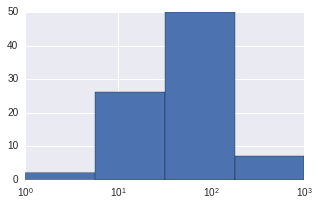

In [41]:
ax = pd.Series(poi_visits).hist(figsize=(5, 3), bins=logbins_visit)
ax.set_xscale('log')

In [42]:
transmat_visit = pd.DataFrame(data=np.zeros((nbins_visit, nbins_visit), dtype=np.float), \
                              columns=np.arange(1, nbins_visit+1), index=np.arange(1, nbins_visit+1))

Count the number of transitions between POI popularity classes.

In [43]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            visit1 = poi_info_.loc[p1, 'nVisit']
            visit2 = poi_info_.loc[p2, 'nVisit']
            vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
            transmat_visit.loc[vc1, vc2] += 1

In [44]:
transmat_visit

,1,2,3,4
1,0,1,0,0
2,0,41,89,19
3,0,92,799,348
4,0,19,329,175


Normalise each row to obtain transition probabilities.

In [45]:
transmat_visit = normalise_transmat(transmat_visit)

In [46]:
transmat_visit

,1,2,3,4
1,0.111111,0.666667,0.111111,0.111111
2,0.023143,0.272838,0.565164,0.138855
3,0.014018,0.084108,0.622734,0.279141
4,0.007061,0.042363,0.618357,0.332219


<a id='sec2.5'></a>

## 2.5 Transition Matrix between POI Average Visit Duration Classes

In [47]:
poi_durations = poi_info_.loc[poi_train_, 'avgDuration']
#sorted(poi_durations.unique().tolist())

Discretize POI average visit duration with uniform log-scale bins (#bins $\le 5$).

In [48]:
nbins_duration = nbins_df.loc[suffix[dat_ix], 'Duration']
print('Number of bins:', nbins_duration)

Number of bins: 3


In [49]:
expo_duration1 = np.log10(max(1, min(poi_durations)))
expo_duration2 = np.log10(max(poi_durations))
print(expo_duration1, expo_duration2)

0.0 3.80257953449


In [50]:
logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins_duration+1)
logbins_duration[0] = 0  # deal with underflow
logbins_duration

array([     0.        ,     21.5443469 ,    464.15888336,  10000.        ])

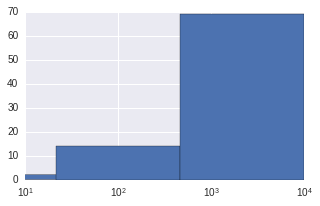

In [51]:
ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
ax.set_xscale('log')

In [52]:
transmat_duration = pd.DataFrame(data=np.zeros((nbins_duration, nbins_duration), dtype=np.float), \
                                 columns=np.arange(1, nbins_duration+1), index=np.arange(1, nbins_duration+1))

Count the number of transitions between POI average visit duration classes.

In [53]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            d1 = poi_info_.loc[p1, 'avgDuration']
            d2 = poi_info_.loc[p2, 'avgDuration']
            dc1, dc2 = np.digitize([d1, d2], logbins_duration)
            transmat_duration.loc[dc1, dc2] += 1

In [54]:
transmat_duration

,1,2,3
1,0,0,1
2,0,16,219
3,1,203,1472


Normalise each row to obtain transition probabilities.

In [55]:
transmat_duration = normalise_transmat(transmat_duration)

In [56]:
transmat_duration

,1,2,3
1,0.125000,0.125000,0.750000
2,0.013083,0.078496,0.908422
3,0.000597,0.121122,0.878282


<a id='sec2.6'></a>

## 2.6 Transition Matrix between POI Neighborhood Classes

Compute POI neighborhoods, i.e., clustering POI (lat, lon) in training set using k-means, #clusters $\le 5$.

KMeans in scikit-learn seems unable to use custom distance metric and no implementation of [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance), use Euclidean distance to approximate.

In [57]:
nclusters = nbins_df.loc[suffix[dat_ix], 'Cluster']
print('Number of clusters:', nclusters)

Number of clusters: 5


In [58]:
X = poi_all.loc[poi_train_, ['poiLon', 'poiLat']]

In [59]:
kmeans = KMeans(n_clusters=nclusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [60]:
clusters = kmeans.predict(X)
#clusters

In [61]:
poi_clusters = pd.DataFrame(data=clusters, index=poi_train_)
poi_clusters.index.name = 'poiID'
poi_clusters.rename(columns={0:'clusterID'}, inplace=True)
#poi_clusters

Scatter plot of POI coordinates with clustering results.

In [62]:
diff = poi_all.loc[poi_train_, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train_, ['poiLon', 'poiLat']].min()
ratio = diff['poiLon'] / diff['poiLat']
#ratio

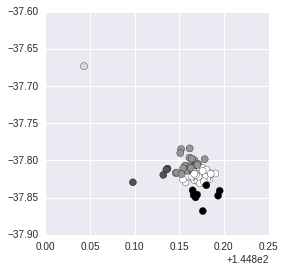

In [63]:
height = 4; width = int(round(ratio)*height)
plt.figure(figsize=[width, height])
plt.scatter(poi_all.loc[poi_train_, 'poiLon'], poi_all.loc[poi_train_, 'poiLat'], c=clusters, s=50)

In [64]:
transmat_neighbor = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                 columns=np.arange(nclusters), index=np.arange(nclusters))

Count the number of transitions between POIs in different clusters.

In [65]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            c1 = poi_clusters.loc[p1, 'clusterID']
            c2 = poi_clusters.loc[p2, 'clusterID']
            transmat_neighbor.loc[c1, c2] += 1

In [66]:
transmat_neighbor

,0,1,2,3,4
0,1153,0,191,5,27
1,0,0,0,0,0
2,227,0,233,8,9
3,6,0,5,0,0
4,28,0,8,0,12


Normalise each row to obtain transition probabilities.

In [67]:
transmat_neighbor = normalise_transmat(transmat_neighbor)

In [68]:
transmat_neighbor

,0,1,2,3,4
0,0.835626,0.000724,0.139030,0.004345,0.020275
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.471340,0.003299,0.483711,0.019794,0.021856
3,0.437500,0.062500,0.375000,0.062500,0.062500
4,0.528571,0.028571,0.171429,0.028571,0.242857


<a id='sec2.7'></a>

## 2.7 Transition Matrix between POIs

Approximate transition probabilities (matrix) between different POI features (vector) using the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of individual transition matrix corresponding to each feature, i.e., POI category, POI popularity (discritized), POI average visit duration (discritized) and POI neighborhoods (clusters).

In [69]:
transmat_value = transmat_cat.values
for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
    transmat_value = kron(transmat_value, transmat.values)

Index of Kronecker product.

In [70]:
transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                     transmat_duration.index, transmat_neighbor.index))

In [71]:
transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
transmat_feature.index.name = '(poiTheme, popularity, avgDuration, clusterID)'
#transmat_feature.head()

In [72]:
print(transmat_cat.shape)
print(transmat_pop.shape)
print(transmat_visit.shape)
print(transmat_duration.shape)
print(transmat_neighbor.shape)
print(transmat_feature.shape)

(9, 9)
(5, 5)
(4, 4)
(3, 3)
(5, 5)
(2700, 2700)


In [73]:
transmat_feature.head()

,"(City precincts, 1, 1, 1, 0)","(City precincts, 1, 1, 1, 1)","(City precincts, 1, 1, 1, 2)","(City precincts, 1, 1, 1, 3)","(City precincts, 1, 1, 1, 4)","(City precincts, 1, 1, 2, 0)","(City precincts, 1, 1, 2, 1)","(City precincts, 1, 1, 2, 2)","(City precincts, 1, 1, 2, 3)","(City precincts, 1, 1, 2, 4)",...,"(Transport, 5, 4, 2, 0)","(Transport, 5, 4, 2, 1)","(Transport, 5, 4, 2, 2)","(Transport, 5, 4, 2, 3)","(Transport, 5, 4, 2, 4)","(Transport, 5, 4, 3, 0)","(Transport, 5, 4, 3, 1)","(Transport, 5, 4, 3, 2)","(Transport, 5, 4, 3, 3)","(Transport, 5, 4, 3, 4)"
"(poiTheme, popularity, avgDuration, clusterID)",,,,,,,,,,,,,,,,,,,,,
"(City precincts, 1, 1, 1, 0)",0.000050,4.310196e-08,0.000008,2.586118e-07,0.000001,0.000050,4.310196e-08,0.000008,2.586118e-07,0.000001,...,0.000141,1.221222e-07,0.000023,7.327334e-07,0.000003,0.000846,7.327334e-07,0.000141,0.000004,0.000021
"(City precincts, 1, 1, 1, 1)",0.000012,1.190476e-05,0.000012,1.190476e-05,0.000012,0.000012,1.190476e-05,0.000012,1.190476e-05,0.000012,...,0.000034,3.373016e-05,0.000034,3.373016e-05,0.000034,0.000202,2.023810e-04,0.000202,0.000202,0.000202
"(City precincts, 1, 1, 1, 2)",0.000028,1.963672e-07,0.000029,1.178203e-06,0.000001,0.000028,1.963672e-07,0.000029,1.178203e-06,0.000001,...,0.000079,5.563738e-07,0.000082,3.338243e-06,0.000004,0.000477,3.338243e-06,0.000489,0.000020,0.000022
"(City precincts, 1, 1, 1, 3)",0.000026,3.720238e-06,0.000022,3.720238e-06,0.000004,0.000026,3.720238e-06,0.000022,3.720238e-06,0.000004,...,0.000074,1.054067e-05,0.000063,1.054067e-05,0.000011,0.000443,6.324405e-05,0.000379,0.000063,0.000063
"(City precincts, 1, 1, 1, 4)",0.000031,1.700680e-06,0.000010,1.700680e-06,0.000014,0.000031,1.700680e-06,0.000010,1.700680e-06,0.000014,...,0.000089,4.818594e-06,0.000029,4.818594e-06,0.000041,0.000535,2.891156e-05,0.000173,0.000029,0.000246


The result of [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) should be normalised to obtain transition probabilities.

In [74]:
#from scipy.misc import logsumexp
logtransmat_feature = np.log(transmat_feature)
for row in range(logtransmat_feature.shape[0]):
    logtransmat_feature.iloc[row] -= logsumexp(logtransmat_feature.iloc[row])
#logtransmat_feature.head()

In [75]:
#logtransmat_feature.max().sort_values(ascending=False).head(10)

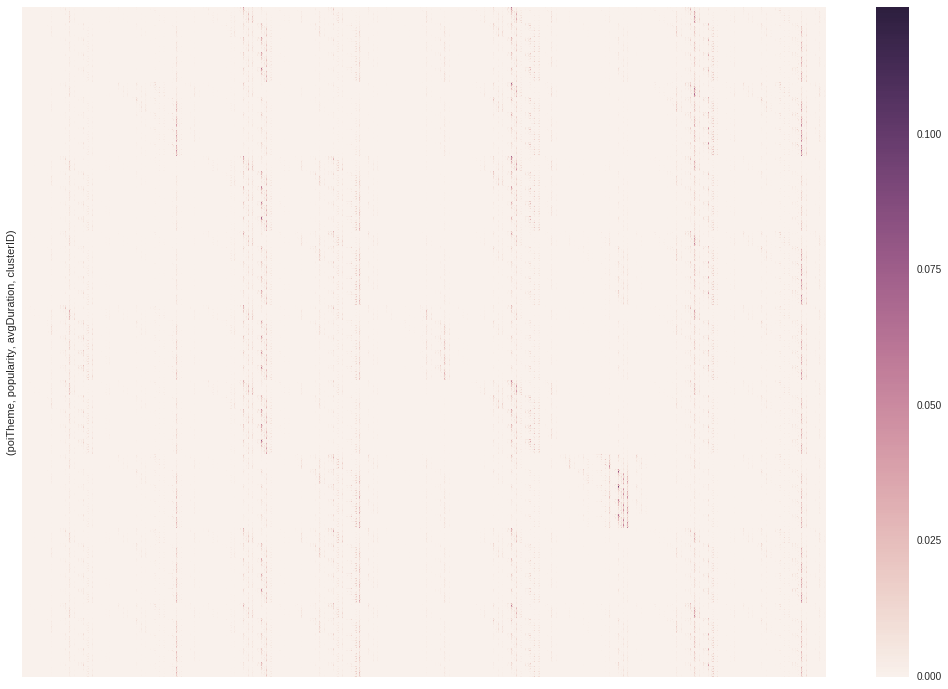

In [76]:
plt.figure(figsize=[18, 12])
sns.heatmap(np.exp(logtransmat_feature), xticklabels=False, yticklabels=False)

Deal with features without corresponding POIs and feature with more than one corresponding POIs. (*Before Normalisation*)
- For features without corresponding POIs, just remove the rows and columns from the matrix obtained by Kronecker product.
- For different POIs with the exact same feature, 
  - Let POIs with the same feature as a POI group,
  - The *incoming* **transition value (i.e., unnormalised transition probability)** of this POI group 
    should be divided uniformly among the group members, 
    *which corresponds to choose a group member uniformly at random in the incoming case*.
  - The *outgoing* transition value should be duplicated (i.e., the same) among all group members, 
    **as we were already in that group in the outgoing case**.
  - For each POI in the group, the allocation transition value of the *self-loop of the POI group* is similar to 
    that in the *outgoing* case, **as we were already in that group**, so just duplicate and then divide uniformly among 
    the transitions from this POI to other POIs in the same group, 
    *which corresponds to choose a outgoing transition uniformly at random from all outgoing transitions
    excluding the self-loop of this POI*.
- **Concretely**, for a POI group with $n$ POIs, 
    1. If the *incoming* transition value of POI group is $m_1$,
       then the corresponding *incoming* transition value for each group member is $\frac{m_1}{n}$.
    1. If the *outgoing* transition value of POI group is $m_2$,
       then the corresponding *outgoing* transition value for each group member is also $m_2$.
    1. If the transition value of *self-loop of the POI group* is $m_3$,
       then transition value of *self-loop of individual POIs* should be $0$,  
       and *other in-group transitions* with value $\frac{m_3}{n-1}$
       as the total number of outgoing transitions to other POIs in the same group is $n-1$ (excluding the self-loop),
       i.e. $n-1$ choose $1$.
       
**NOTE**: execute the above division before or after row normalisation will lead to the same result, *as the division itself does NOT change the normalising constant of each row (i.e., the sum of each row before normalising)*.

In [77]:
feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
poi_features = pd.DataFrame(data=np.zeros((len(poi_train_), len(feature_names))), \
                            columns=feature_names, index=poi_train_)
poi_features.index.name = 'poiID'

In [78]:
poi_features['poiCat'] = poi_info_.loc[poi_train_, 'poiCat']
poi_features['popularity'] = np.digitize(poi_info_.loc[poi_train_, 'popularity'], logbins_pop)
poi_features['nVisit'] = np.digitize(poi_info_.loc[poi_train_, 'nVisit'], logbins_visit)
poi_features['avgDuration'] = np.digitize(poi_info_.loc[poi_train_, 'avgDuration'], logbins_duration)
poi_features['clusterID'] = poi_clusters.loc[poi_train_, 'clusterID']

In [79]:
poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train_), len(poi_train_)), dtype=np.float), \
                               columns=poi_train_, index=poi_train_)

Copy transition values between features with corresponding POIs.

In [80]:
for p1 in poi_logtransmat.index:
    rix = tuple(poi_features.loc[p1])
    for p2 in poi_logtransmat.columns:
        cix = tuple(poi_features.loc[p2])
        value_ = transmat_feature.loc[(rix,), (cix,)]
        #print(value_.values)
        poi_logtransmat.loc[p1, p2] = value_.values[0, 0]
#poi_logtransmat.head()

Deal with POI features that correspond to more than once POIs.

In [81]:
features_dup = dict()
for poi in poi_features.index:
    key = tuple(poi_features.loc[poi])
    if key in features_dup:
        features_dup[key].append(poi)
    else:
        features_dup[key] = [poi]
features_dup

{('City precincts', 2, 2, 3, 0): [5, 6],
 ('City precincts', 3, 3, 2, 0): [0],
 ('City precincts', 3, 3, 2, 2): [3],
 ('City precincts', 3, 3, 3, 2): [1, 4, 7],
 ('City precincts', 4, 3, 3, 0): [2],
 ('Entertainment', 3, 3, 3, 2): [28],
 ('Entertainment', 4, 3, 3, 0): [25, 27],
 ('Entertainment', 4, 3, 3, 4): [26],
 ('Institutions', 2, 2, 2, 0): [43],
 ('Institutions', 2, 2, 3, 0): [33],
 ('Institutions', 3, 3, 2, 2): [42],
 ('Institutions', 3, 3, 3, 0): [34, 39],
 ('Institutions', 3, 3, 3, 2): [36, 37, 38],
 ('Institutions', 4, 3, 3, 0): [40],
 ('Institutions', 4, 3, 3, 2): [41],
 ('Institutions', 4, 4, 3, 0): [35],
 ('Institutions', 4, 4, 3, 2): [32],
 ('Parks and spaces', 1, 3, 1, 2): [77],
 ('Parks and spaces', 2, 2, 2, 0): [79],
 ('Parks and spaces', 2, 2, 3, 0): [74],
 ('Parks and spaces', 2, 2, 3, 4): [66],
 ('Parks and spaces', 3, 2, 2, 0): [72],
 ('Parks and spaces', 3, 2, 3, 0): [75, 78],
 ('Parks and spaces', 3, 2, 3, 4): [76],
 ('Parks and spaces', 3, 3, 2, 2): [69, 73],
 (

In [82]:
for feature in sorted(features_dup.keys()):
    n = len(features_dup[feature])
    if n > 1:
        group = features_dup[feature]
        v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
        
        # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
        for poi in group:
            poi_logtransmat[poi] /= n
        
        # outgoing transition value has already been duplicated (value copied above)
        
        # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
        # from a POI to all other POIs in the same group (excluding POI self-loop)
        v2 = v1 / (n - 1)
        for pair in itertools.permutations(group, 2):
            poi_logtransmat.loc[pair[0], pair[1]] = v2

Make the transition value of all self-loops of POIs to $0$.

In [83]:
for p1 in poi_logtransmat.index:
    poi_logtransmat.loc[p1, p1] = 0
#poi_logtransmat.head()

Normalise and compute log probability.

In [84]:
for p1 in poi_logtransmat.index:
    rowsum = poi_logtransmat.loc[p1].sum()
    assert(rowsum > 0)
    logrowsum = np.log10(rowsum)
    for p2 in poi_logtransmat.columns:
        if p1 == p2:
            poi_logtransmat.loc[p1, p2] = -np.inf  # deal with log(0) explicitly
        else:
            poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum
poi_logtransmat.head()

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,-inf,-3.222641,-1.658921,-3.808963,-3.222641,-3.926602,-3.926602,-3.222641,-1.181800,-1.229249,...,-5.702459,-2.684813,-4.236717,-5.457329,-1.206623,-1.555102,-9.633377,-1.985528,-3.048971,-6.520772
1,-3.017704,-inf,-1.849598,-3.006453,-2.447071,-4.117279,-4.117279,-2.447071,-1.372477,-1.419926,...,-6.429294,-2.875491,-4.224364,-4.740757,-1.397301,-1.745780,-10.243118,-1.386049,-2.246461,-5.601169
2,-2.913211,-3.308825,-inf,-3.692116,-3.308825,-4.091057,-4.091057,-3.308825,-1.152849,-1.200298,...,-8.017136,-2.770997,-4.198141,-5.621784,-1.177673,-1.526152,-11.948054,-1.956577,-2.816989,-6.482196
3,-3.216128,-2.618555,-1.844991,-inf,-2.618555,-4.112672,-4.112672,-2.618555,-1.367870,-1.415319,...,-5.098372,-2.870883,-4.422787,-4.736149,-1.392693,-1.741172,-8.912197,-1.381441,-2.444884,-5.799592
4,-3.017704,-2.447071,-1.849598,-3.006453,-inf,-4.117279,-4.117279,-2.447071,-1.372477,-1.419926,...,-6.429294,-2.875491,-4.224364,-4.740757,-1.397301,-1.745780,-10.243118,-1.386049,-2.246461,-5.601169


Plot transition matrix heatmap.

In [85]:
prob_mat = np.power(10, poi_logtransmat)

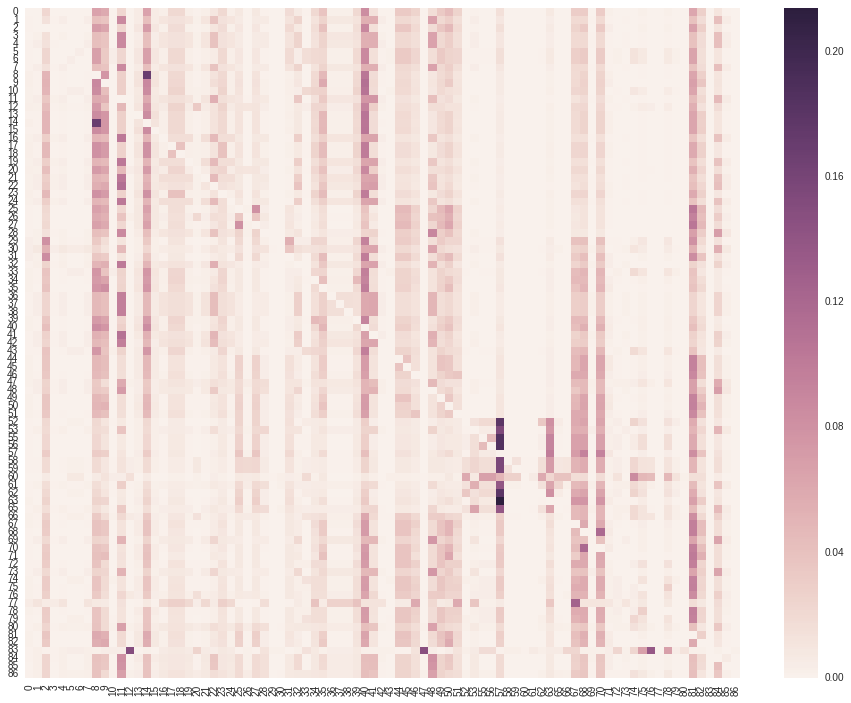

In [86]:
plt.figure(figsize=[16, 12])
sns.heatmap(prob_mat)